# Trends in College Basketball
### By Evan Devore and Mat Steininger

Sports and data science have taken an explosive growth in the past few decades with prominent examples like Moneyball, SportVU in the NBA, and almost every major professional sport’s teams hiring data analysts to gain a competitive edge. This is no surprise; teams will do anything they can to win more championships and increase their revenue. The sports analytics industry is expected to balloon to $4.5 billion dollars in the next few years, according to https://www.businesswire.com/news/home/20181205005823/en/Global-4.5-Billion-Sports-Analytics-Market-Forecasts. 

One such sport where data analytics has had a significant impact is professional basketball. However, with this tutorial, we are going to investigate the world of NCAA Men’s College Basketball. Like professional sports, college teams use all sorts of analytics like game statistics all the way to movement data in order to gain a competitive edge. For more information on how analytics is affecting college basketball, see this article by Bleacher Report: https://bleacherreport.com/articles/2807432-the-analytics-uprising-is-upon-college-basketball-how-it-could-alter-the-sport.

In our tutorial, we are going to compare Final AP #1 teams across years of NCAA Men’s College Basketball. For those unaware, the AP Polls are the NCAA standard for ranking teams and are decided by the media. At the end of each year, the final rankings show which teams are regarded as the best teams going into the NCAA tournament, and which squad is widely considered the best team of that regular season.

This tutorial will be organized based on the Data Science Pipeline that we learned in CMSC 320:
1.	Data Collection
2.	Data Processing
3.	Exploratory Data Analysis and Visualization
4.	Hypothesis Testing and Machine Learning
5.	Final Thoughts

# Part 1 - Data Collection

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
base_url = 'https://www.sports-reference.com'

# Data Frame for all #1 teams
top_teams = pd.DataFrame()

# Looping through every year from 1949 (Start of AP polling) to most recent final AP Poll in 2020
for year in range(1949, 2021):
    # Sports-Reference uses a simple year as the page format
    season_url = base_url + '/cbb/seasons/' + str(year) + '.html'
    season_request = requests.get(season_url).text
    soup = BeautifulSoup(season_request, features='lxml')

    # Find on the page where AP Final #1 is found and extract team page and name
    ap_final = soup.find(text=re.compile('AP Final #1')).parent.parent.parent.find("a")
    team_page_url = ap_final.get("href")
    team_name = ap_final.text

    # Now go into each team page and extra data
    team_page_request = requests.get(base_url + team_page_url).text
    soup = BeautifulSoup(team_page_request, features='lxml')
    table_team_data = soup.find(id="team_stats")
    if table_team_data is None:
        # No team data exists for this team for this season
        continue
    table_team_data = table_team_data.findAll("tr")

    # Create data frame to append to, year will be index
    year = team_page_url[team_page_url.rfind("/") + 1:team_page_url.find(".html")]
    team_data = pd.DataFrame(index=[year])
    team_data['team'] = team_name
    # Gets year from url

    # First row is labels for stats
    # Second row is teams stats for
    for entries in table_team_data[1].findAll("td"):
        stat = entries.get("data-stat")
        team_data[stat] = entries.text

    # Third row is teams stats against. Some years have different third row, so this takes that into account
    against = 2
    if len(table_team_data) > 3:
        against = -2
    for entries in table_team_data[against].findAll("td"):
        stat = entries.get("data-stat") # + '_against'
        team_data[stat] = entries.text

    # Append our row to the ongoing list of AP #1 teams
    top_teams = top_teams.append(team_data)


# Move team name to the front of the df
names = top_teams['team']
top_teams.drop(['team'], axis = 1, inplace = True)
top_teams.insert(0, 'team_name', names)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [3]:
top_teams.columns

Index(['team_name', 'ast', 'blk', 'drb', 'fg', 'fg2', 'fg2_pct', 'fg2a', 'fg3',
       'fg3_pct', 'fg3a', 'fg_pct', 'fga', 'ft', 'ft_pct', 'fta', 'g', 'mp',
       'opp_ast', 'opp_blk', 'opp_drb', 'opp_fg', 'opp_fg2', 'opp_fg2_pct',
       'opp_fg2a', 'opp_fg3', 'opp_fg3_pct', 'opp_fg3a', 'opp_fg_pct',
       'opp_fga', 'opp_ft', 'opp_ft_pct', 'opp_fta', 'opp_orb', 'opp_pf',
       'opp_pts', 'opp_pts_per_g', 'opp_stl', 'opp_tov', 'opp_trb', 'orb',
       'pf', 'pts', 'pts_per_g', 'stl', 'tov', 'trb'],
      dtype='object')

In [4]:
top_teams.tail()

team_name  ast  blk   drb    fg  fg2 fg2_pct  fg2a  fg3 fg3_pct  ...  \
2016     Kansas  604  158  1041  1092  788    .533  1479  304    .418  ...   
2017  Villanova  505  109   892   965  654    .592  1105  311    .369  ...   
2018   Virginia  458  124   817   848  601    .501  1199  247    .383  ...   
2019       Duke  606  257  1072  1157  879    .580  1515  278    .308  ...   
2020     Kansas  432  145   863   851  652    .553  1180  199    .344  ...   

     opp_stl opp_tov opp_trb  orb   pf   pts pts_per_g  stl  tov   trb  
2016     248     490    1234  402  719  3089      81.3  253  478  1443  
2017     185     475    1073  316  515  2779      77.2  259  402  1208  
2018     130     432    1048  282  480  2283      67.1  232  290  1099  
2019     243     540    1348  495  595  3143      82.7  346  488  1567  
2020     199     407     991  333  454  2312      74.6  237  396  1196  

[5 rows x 47 columns]

### Data Collection Tutorial

To start, we head over to the vast database of sports statistics over at https://www.sports-reference.com, which has both AP Final #1 teams and also that team’s complete season statistics. The reason we chose AP Final #1 and not NCAA Tournament Champion is because the tournament is unpredictable, and some teams start playing well just at the right time. However, with AP Final #1 teams, they are a better representation of the best college basketball team over the course of the entire regular season, and thus have the statistics that represent the best team from that year. 

Navigating and scraping data from this website is difficult because there is no single table with all the statistics we need. Firstly, each college basketball season has its own page which ends in year.html, so we can simply use the HTTP requests library in conjunction with BeautifulSoup to get the html of every season starting from when the first AP polling occurred in 1949. Then, by building the URL of each season, we can then find the AP Final #1 team and go to their respective page where all that season’s data is nicely represented in a table. Certain years have less or no data because some statistics were not tracked until later seasons.

At this point, we have found an abundance of CBB data from each season's AP Poll 'Best Team' for each season starting at 1949, and loaded into the top_teams DataFrame. All of the columns for statistics from the team's opponent start with the opp_ prefix. For example, the Total Rebounds statistic is kept under the 'trb' column, but opponent total rebounds are kept under the 'opp_trb' column. Additionally, the index of the row is the year in which the season was played. Furthermore, the final row in the DataFrame is the from 2019-2020 season.

# Part 2 - Data Processing
Let's convert all of the columns to their proper datatypes. A float is necessary for columns that are percentages or per game values. Integers will suffice for the rest.

In [5]:
# Convert non-name columns to float or int
import numpy as np
from plotnine import *

top_teams.replace(r'^\s*$', np.nan, regex=True, inplace = True)
for column in top_teams:
    if not column == 'team_name':
        top_teams[column] = top_teams[column].fillna(-1)
        if ('pct' in column) or ('per_g' in column):
            top_teams[column] = top_teams[column].astype(float)
        else:
            top_teams[column] = top_teams[column].astype(int)
    print(column + " type is " + str(type(top_teams[column][-1])))

team_name type is <class 'str'>
ast type is <class 'numpy.int64'>
blk type is <class 'numpy.int64'>
drb type is <class 'numpy.int64'>
fg type is <class 'numpy.int64'>
fg2 type is <class 'numpy.int64'>
fg2_pct type is <class 'numpy.float64'>
fg2a type is <class 'numpy.int64'>
fg3 type is <class 'numpy.int64'>
fg3_pct type is <class 'numpy.float64'>
fg3a type is <class 'numpy.int64'>
fg_pct type is <class 'numpy.float64'>
fga type is <class 'numpy.int64'>
ft type is <class 'numpy.int64'>
ft_pct type is <class 'numpy.float64'>
fta type is <class 'numpy.int64'>
g type is <class 'numpy.int64'>
mp type is <class 'numpy.int64'>
opp_ast type is <class 'numpy.int64'>
opp_blk type is <class 'numpy.int64'>
opp_drb type is <class 'numpy.int64'>
opp_fg type is <class 'numpy.int64'>
opp_fg2 type is <class 'numpy.int64'>
opp_fg2_pct type is <class 'numpy.float64'>
opp_fg2a type is <class 'numpy.int64'>
opp_fg3 type is <class 'numpy.int64'>
opp_fg3_pct type is <class 'numpy.float64'>
opp_fg3a type is 

In [6]:
top_teams.head()

team_name  ast  blk  drb    fg  fg2  fg2_pct  fg2a  fg3  fg3_pct  ...  \
1949  Kentucky   -1   -1   -1   903   -1     -1.0    -1   -1     -1.0  ...   
1951  Kentucky  471   -1   -1  1029   -1     -1.0    -1   -1     -1.0  ...   
1952  Kentucky  497   -1   -1  1043   -1     -1.0    -1   -1     -1.0  ...   
1953   Indiana   -1   -1   -1   737   -1     -1.0    -1   -1     -1.0  ...   
1954  Kentucky   -1   -1   -1   829   -1     -1.0    -1   -1     -1.0  ...   

      opp_stl  opp_tov  opp_trb  orb   pf   pts  pts_per_g  stl  tov   trb  
1949       -1     1530       -1   -1  636  2320       68.2   -1   -1    -1  
1951       -1       -1     1357   -1  684  2540       74.7   -1   -1  2109  
1952       -1       -1     1164   -1  707  2635       82.3   -1   -1  1817  
1953       -1       -1      792   -1  620  2112       81.2   -1   -1  1005  
1954       -1       -1      851   -1  582  2187       87.5   -1   -1  1318  

[5 rows x 47 columns]

In [7]:
top_teams.tail()

team_name  ast  blk   drb    fg  fg2  fg2_pct  fg2a  fg3  fg3_pct  ...  \
2016     Kansas  604  158  1041  1092  788    0.533  1479  304    0.418  ...   
2017  Villanova  505  109   892   965  654    0.592  1105  311    0.369  ...   
2018   Virginia  458  124   817   848  601    0.501  1199  247    0.383  ...   
2019       Duke  606  257  1072  1157  879    0.580  1515  278    0.308  ...   
2020     Kansas  432  145   863   851  652    0.553  1180  199    0.344  ...   

      opp_stl  opp_tov  opp_trb  orb   pf   pts  pts_per_g  stl  tov   trb  
2016      248      490     1234  402  719  3089       81.3  253  478  1443  
2017      185      475     1073  316  515  2779       77.2  259  402  1208  
2018      130      432     1048  282  480  2283       67.1  232  290  1099  
2019      243      540     1348  495  595  3143       82.7  346  488  1567  
2020      199      407      991  333  454  2312       74.6  237  396  1196  

[5 rows x 47 columns]

### Data Processing Tutorial

Processing the data is another crucial step in our pipeline of analyzing this college basketball data. We attempted to use proper data science practice to make sure the top_teams pandas dataframe has labels and variable names that are accurate and concise and match the original dataset we scraped.

As you can see, all of the missing data has been encoded as -1, but the recent data is much more complete. In the original dataset, missing data was simply encoded with an empty string, so we used a simple regular expression to find the missing values. We have consciously decided to use -1 as the encoding for a missing value because it allows us to keep columns that should be integer values as such in our next step, not forcing them to be floating point numbers. This should save us some storage space. If we want to do any analysis on a column with missing data, we will just drop all of the columns that contain a -1 as that column's value before exploring it.

Finally, we convert all of the columns to their proper datatype. If a column involved a percentage or per_game value, then we encoded it as a float. Otherwise, the column's data was stored as a string. Excluding the team_name column, which is a string, all of our data is now in it's proper numeric datatype. 

You can see that we've printed out the datatype of each column for convenience, as well as the head and tail of the dataset.

We are now ready to explore what makes a good NCAA basketball team.

# Part 3 - Exploratory Data Analysis
Let's start by finding out which schools have been the most successful at producing the AP Poll #1 Ranked team at the end of each season.

In [8]:
# Let's see which colleges have been AP Poll #1 ranked the most often, after each season
counts = top_teams.filter(['team_name', 'pts']).groupby(['team_name']).count()
counts['team_name'] = counts.index
counts.reset_index(drop = True, inplace = True)
counts.sort_values(by=['pts'], ascending = False, inplace = True)

In [9]:
(ggplot(counts, aes(x= 'team_name', y = 'pts')) +
theme(axis_text_x = element_text(angle=90)) +
xlab('School') + 
ylab('Number of AP Poll Final #1 Finishes') +
ggtitle('Number of AP Final #1 Finishes by School') +
scale_y_continuous(breaks=[2, 4, 6, 8, 10]) +
geom_col(width = 0.5))

<ggplot: (282868461)>

Kentucky has acheived this feat a whopping 10 times. Duke and UCLA aren't far behind with 8 times, with North Carolina, Kansas, and Ohio State behind them at 4 times.

In [10]:
# Let's see how some key parts of basketball have changed over time. Let's start with points.
points = top_teams.filter(['team_name', 'pts_per_g', 'opp_pts_per_g'])
points['year'] = points.index.astype(int)
points.reset_index(drop = True, inplace = True)
points['differential'] = points['pts_per_g'] - points['opp_pts_per_g']
points.tail()

team_name  pts_per_g  opp_pts_per_g  year  differential
66     Kansas       81.3           67.6  2016          13.7
67  Villanova       77.2           62.7  2017          14.5
68   Virginia       67.1           54.0  2018          13.1
69       Duke       82.7           67.8  2019          14.9
70     Kansas       74.6           60.7  2020          13.9

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


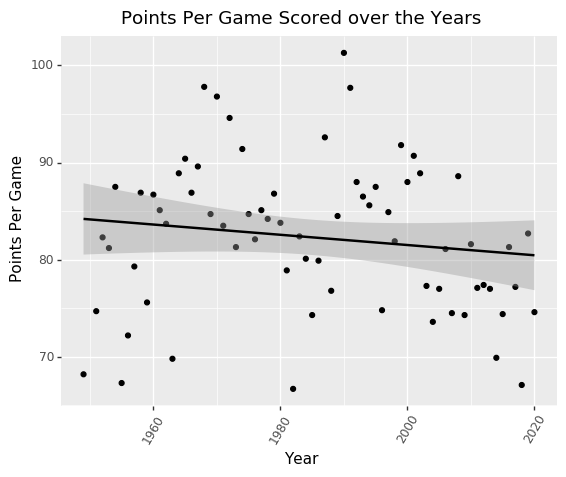

<ggplot: (7557518785)>

In [11]:
(ggplot(points, aes(x= 'year', y = 'pts_per_g')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Points Per Game') +
ggtitle('Points Per Game Scored over the Years') +
geom_smooth(method = 'lm'))

In [12]:
import statsmodels.formula.api as sm
ppg_res = sm.ols('year~pts_per_g', data=points).fit()
ppg_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.409
Date:                Sun, 17 May 2020   Prob (F-statistic):              0.239
Time:                        16:05:44   Log-Likelihood:                -314.54
No. Observations:                  71   AIC:                             633.1
Df Residuals:                      69   BIC:                             637.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2016.2214     26.426     76.295      0.000    1963.502    2068.941
pts_per_g     -0.3795      0.320     -1.187      0.239      -1.017       0.258
==============================================================================
Omnibus:                       13.220   Durbin-Watson:                   0.030
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                3.928
Skew:                          -0.185   Prob(JB):                        0.140
Kurtosis:                       1.909   Cond. No.                         893.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From this plot, you can see that there may be a slight drop in points per game over the years by CBB's best teams. 
However, by checking the summary of this model, there is no statistically significant difference we can detect. 

In [13]:
(ggplot(points, aes(x= 'year', y = 'differential')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Score Differential') +
ggtitle('Score Differential over the Years') +
geom_smooth(method = 'lm'))

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<ggplot: (7558012337)>

In [14]:
diff_res = sm.ols('year~differential', data=points).fit()
diff_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     8.196
Date:                Sun, 17 May 2020   Prob (F-statistic):            0.00556
Time:                        16:05:44   Log-Likelihood:                -311.27
No. Observations:                  71   AIC:                             626.5
Df Residuals:                      69   BIC:                             631.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2010.7460      9.296    216.297      0.000    1992.201    2029.292
differential    -1.5203      0.531     -2.863      0.006      -2.580      -0.461
==============================================================================
Omnibus:                       15.692   Durbin-Watson:                   0.192
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                3.856
Skew:                          -0.011   Prob(JB):                        0.145
Kurtosis:                       1.858   Cond. No.                         69.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

On the other hand, the best teams aren't winning by nearly as much anymore.
This does have a statistically significant difference, providing a modeling equation of differential = 2010.7460 - 1.5203(year)
with a p-value of .006. In context, this means that over the years, CBB games have gotten closer over time, and the best teams don't blow out their opponents nearly as often.

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


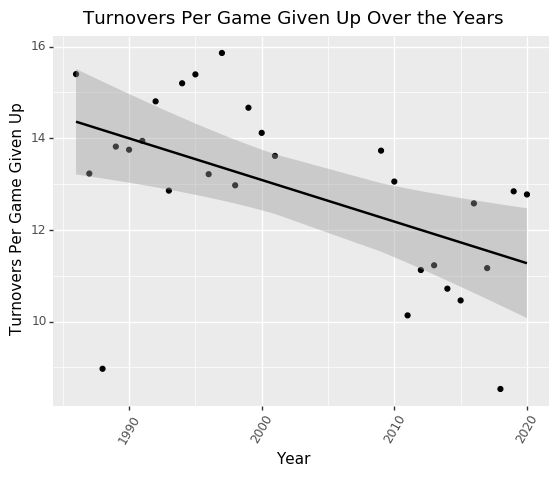

<ggplot: (7557605773)>

In [15]:
turnovers = top_teams.filter(['g','tov', 'opp_tov'])

# Some teams play more games, so we create a new statistic for both forced and given up turnovers per game played
turnovers['tov_per_g'] = turnovers['tov'] / turnovers['g']
turnovers['opp_tov_per_g'] = turnovers['opp_tov'] / turnovers['g']

# Let's also find the differential in turnovers.
turnovers['differential'] = turnovers['opp_tov_per_g'] - turnovers['tov_per_g']

# Convert year to a column
turnovers['year'] = turnovers.index.astype(int)
turnovers.reset_index(drop = True, inplace = True)

# Ignore all columns with missing values
turnovers = turnovers[(turnovers != -1).all(1)]

# Plot
(ggplot(turnovers, aes(x= 'year', y = 'tov_per_g')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Turnovers Per Game Given Up') +
ggtitle('Turnovers Per Game Given Up Over the Years') +
geom_smooth(method = 'lm'))

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


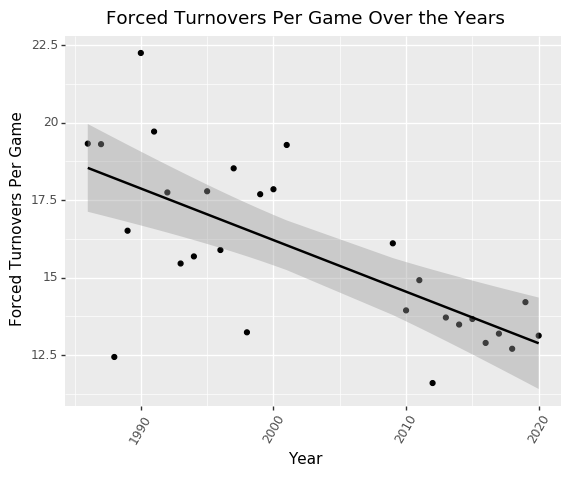

<ggplot: (7558150625)>

In [16]:
(ggplot(turnovers, aes(x= 'year', y = 'opp_tov_per_g')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Forced Turnovers Per Game') +
ggtitle('Forced Turnovers Per Game Over the Years') +
geom_smooth(method = 'lm'))

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


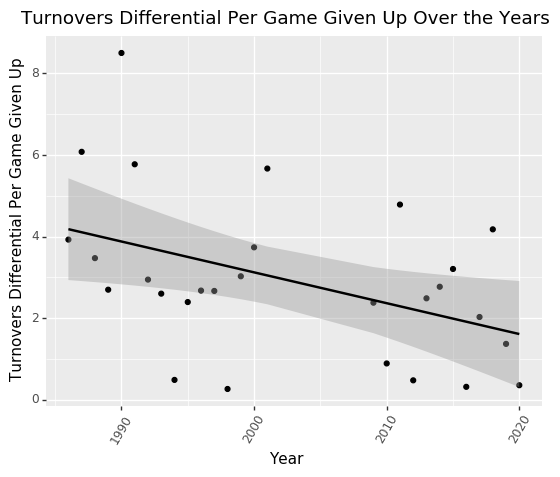

<ggplot: (7558164333)>

In [17]:
(ggplot(turnovers, aes(x= 'year', y = 'differential')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Turnovers Differential Per Game Given Up') +
ggtitle('Turnovers Differential Per Game Given Up Over the Years') +
geom_smooth(method = 'lm'))

In [18]:
turnover_diff = sm.ols('year~differential', data=turnovers).fit()
turnover_diff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     6.166
Date:                Sun, 17 May 2020   Prob (F-statistic):             0.0198
Time:                        16:05:45   Log-Likelihood:                -104.38
No. Observations:                  28   AIC:                             212.8
Df Residuals:                      26   BIC:                             215.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2009.9355      3.586    560.462      0.000    2002.564    2017.307
differential    -2.5350      1.021     -2.483      0.020      -4.634      -0.436
==============================================================================
Omnibus:                        7.974   Durbin-Watson:                   0.354
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                2.120
Skew:                           0.088   Prob(JB):                        0.346
Kurtosis:                       1.664   Cond. No.                         6.75
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The change in turnover differential does have a statistically significant difference, providing a modeling equation of differential = 2009.9355 - 2.5350(year) with a p-value of .020. In context, this means that over the years, the best teams protect the ball on offense, knowing that they must not waste possessions by giving it away to the other team. The best teams outplay their opponents in the turnover categories, with the differential being > 0, despite steadily dropping over the years as offenses protect the ball more.

Turnovers have evolved into an important statistic in basketball. The best teams turn over the ball less often per game, but this also leads to their opponents turning the ball over less frequently too. We will see that this smaller number of possessions will lead to the rise of the 3-pointer (a way to score more points per possession than the standard 2 point shot) and promote a more efficient style of basketball.

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


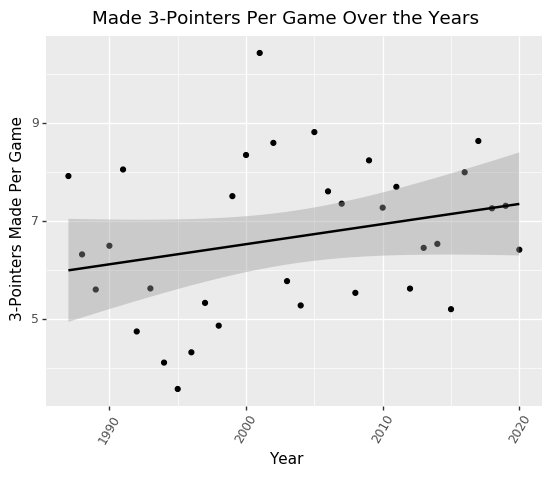

<ggplot: (7558436173)>

In [19]:
threes = top_teams.filter(['g','fg3_pct', 'fg3', 'fg3a'])

# Some teams play more games, so we create a new statistic based on games played
threes['fg3_per_g'] = threes['fg3'] / threes['g']
threes['fg3a_per_g'] = threes['fg3a'] / threes['g']

# Convert year to a column
threes['year'] = threes.index.astype(int)
threes.reset_index(drop = True, inplace = True)
threes = threes[(threes != -1).all(1)]

# Plot
(ggplot(threes, aes(x= 'year', y = 'fg3_per_g')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('3-Pointers Made Per Game') +
ggtitle('Made 3-Pointers Per Game Over the Years') +
geom_smooth(method = 'lm'))

In [20]:
three_point_made = sm.ols('year~fg3_per_g', data=threes).fit()
three_point_made.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.332
Date:                Sun, 17 May 2020   Prob (F-statistic):              0.137
Time:                        16:05:45   Log-Likelihood:                -124.69
No. Observations:                  34   AIC:                             253.4
Df Residuals:                      32   BIC:                             256.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1992.4627      7.419    268.548      0.000    1977.350    2007.576
fg3_per_g      1.6533      1.083      1.527      0.137      -0.552       3.859
==============================================================================
Omnibus:                        2.848   Durbin-Watson:                   0.093
Prob(Omnibus):                  0.241   Jarque-Bera (JB):                1.390
Skew:                          -0.033   Prob(JB):                        0.499
Kurtosis:                       2.012   Cond. No.                         31.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

While the number of made three pointers per game has increased over the years since it's addition to the NCAA in 1986, the jump is not statistically significant with a p-value of 0.137.

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


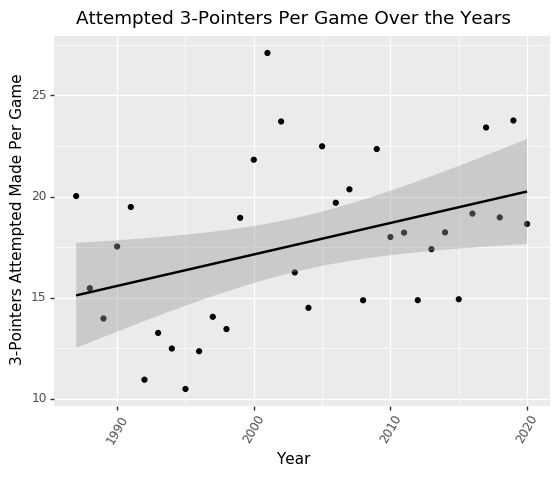

<ggplot: (7558357357)>

In [21]:
(ggplot(threes, aes(x= 'year', y = 'fg3a_per_g')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('3-Pointers Attempted Made Per Game') +
ggtitle('Attempted 3-Pointers Per Game Over the Years') +
geom_smooth(method = 'lm'))

In [22]:
three_point_att = sm.ols('year~fg3a_per_g', data=threes).fit()
three_point_att.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     5.490
Date:                Sun, 17 May 2020   Prob (F-statistic):             0.0255
Time:                        16:05:46   Log-Likelihood:                -123.19
No. Observations:                  34   AIC:                             250.4
Df Residuals:                      32   BIC:                             253.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1986.8680      7.277    273.035      0.000    1972.045    2001.691
fg3a_per_g     0.9406      0.401      2.343      0.026       0.123       1.758
==============================================================================
Omnibus:                        2.603   Durbin-Watson:                   0.196
Prob(Omnibus):                  0.272   Jarque-Bera (JB):                1.362
Skew:                          -0.097   Prob(JB):                        0.506
Kurtosis:                       2.039   Cond. No.                         82.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

On the other hand, the number of 3 point shots attempted has jumped in a statistically significant way, increasing by almost 1 for every year after 1987. The best teams in the NCAA have realized that the 3 pointer is the best 'bang for your buck shot' when compared to other jumpshots. Why shoot a jump shot from 20ft for 2 points, when you can step back another foot for a 3rd point? It only makes sense. The rising prominence of the three point shot changes the fundamental composition of basketball teams, making it less about height and bullying the other guy at the rim, and more about strategy and spacing of the court and good shooters.

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


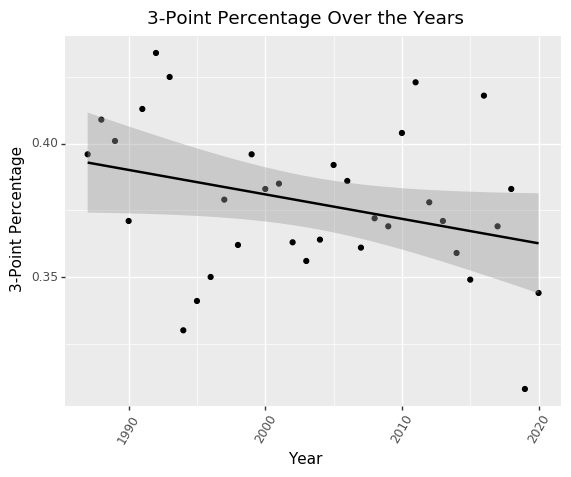

<ggplot: (282874361)>

In [23]:
(ggplot(threes, aes(x= 'year', y = 'fg3_pct')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('3-Point Percentage') +
ggtitle('3-Point Percentage Over the Years') +
geom_smooth(method = 'lm'))

It seems that the best teams are shooting more threes over time, yet making them at a worse percentage. Let's find the teams that were most efficient in their offenses.
Since the possesions statistic is not avaliable, we must calculate it using an estimation formula provided by https://www.sportsrec.com/calculate-teams-offensive-defensive-efficiencies-7775395.html

#### Possessions = Field Goals Attempted - Offensive Rebounds + Turnovers + (0.4 x free throws attempted)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


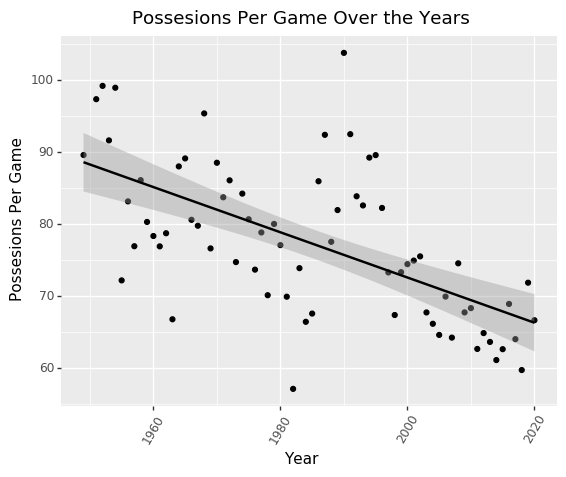

<ggplot: (7558121733)>

In [24]:
# We will be calculating possesions per game
efficiency = top_teams.filter(['g', 'pts', 'opp_pts', 'fga', 'fta', 'orb', 'opp_drb', 'fg', 'tov', 'opp_fga', 'opp_FTA', 'opp_orb', 'drb', 'opp_fg', 'opp_tov', 'opp_fta', 'fg3a'])

# Every stat converted to its per game equivalency
efficiency = efficiency.div(efficiency['g'], axis=0)

# Add team name
efficiency.insert(0, 'team_name', top_teams['team_name'])

# Estimating possesions
# field goals attempted - offensive rebounds + turnovers + (0.4 x free throws attempted) = total number of possessions
possesions = efficiency['fga'] - efficiency['orb'] + efficiency['tov'] + (0.4 * efficiency['fta'])

# Insert columns for possessions and year
efficiency.insert(1, 'possesions', possesions)
efficiency['year'] = efficiency.index.astype(int)

# Plot
(ggplot(efficiency, aes(x= 'year', y = 'possesions')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Possesions Per Game') +
ggtitle('Possesions Per Game Over the Years') +
geom_smooth(method = 'lm'))

Now that we have a possessions estimate, we can calculate offensive efficiency for each team. The simple formula can be found on https://www.nbastuffer.com/analytics101/offensive-efficiency/

#### Offensive Efficiency Formula=(Points Scored)/(Possessions)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


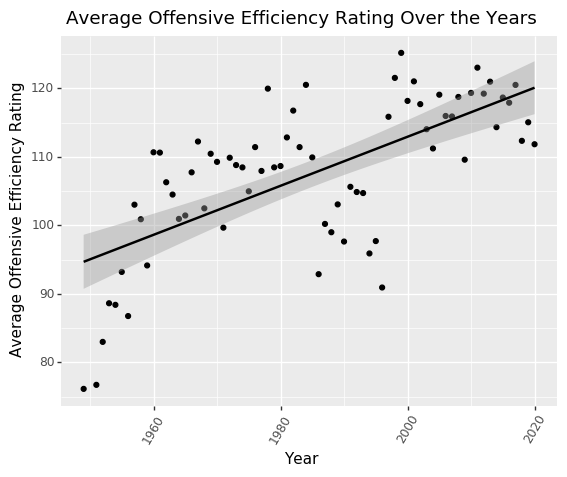

<ggplot: (7558128877)>

In [25]:
# Now we can calculate offensive efficiency
offensive = 100 * efficiency['pts'] / efficiency['possesions']
efficiency.insert(1, 'offensive', offensive)

# Plot
(ggplot(efficiency, aes(x= 'year', y = 'offensive')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Average Offensive Efficiency Rating') +
ggtitle('Average Offensive Efficiency Rating Over the Years') +
geom_smooth(method = 'lm'))

In [26]:
off_eff = sm.ols('year~offensive', data=efficiency).fit()
off_eff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     56.28
Date:                Sun, 17 May 2020   Prob (F-statistic):           1.62e-10
Time:                        16:05:47   Log-Likelihood:                -294.08
No. Observations:                  71   AIC:                             592.2
Df Residuals:                      69   BIC:                             596.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1849.9345     18.094    102.237      0.000    1813.837    1886.032
offensive      1.2557      0.167      7.502      0.000       0.922       1.590
==============================================================================
Omnibus:                        8.157   Durbin-Watson:                   0.339
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                2.983
Skew:                           0.113   Prob(JB):                        0.225
Kurtosis:                       2.022   Cond. No.                     1.07e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
efficiency[efficiency['offensive'] == efficiency['offensive'].max()]

team_name   offensive  possesions    g        pts    opp_pts        fga  \
1999      Duke  125.166026   73.358974  1.0  91.820513  67.153846  62.102564   

            fta        orb    opp_drb         fg        tov   opp_fga  \
1999  29.102564  15.051282  18.897436  31.897436  14.666667  63.74359   

        opp_orb        drb     opp_fg    opp_tov    opp_fta       fg3a  year  
1999  14.512821  27.128205  24.923077  17.692308  18.717949  18.948718  1999

As predicted, team strategies have evolved to be much more offensively efficient. The lack of extra possessions caused by an opponent's turnover has sped up this shift in play. The best teams typically gain 1.25 offensive efficiency rating points each year. The peak of offensive efficiency in our dataset was by the 1999 Duke team with an offensive efficiency rating of 125.17.

Now, let's do the same thing with defensive efficiency, calculating by the formula found on https://www.nbastuffer.com/analytics101/defensive-efficiency/

#### Defensive Efficiency = 100 * (Points Allowed / Possessions)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


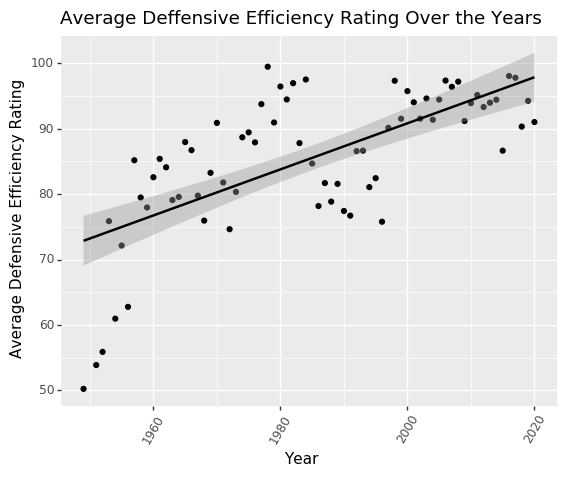

<ggplot: (7557927033)>

In [28]:
# Now let's calculate defesnive efficiency
# Defensive Efficiency Fomula=100*(Points Allowed/Possessions)

defensive = 100 * efficiency['opp_pts'] / efficiency['possesions']
efficiency.insert(1, 'defensive', defensive)

(ggplot(efficiency, aes(x= 'year', y = 'defensive')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Average Defensive Efficiency Rating') +
ggtitle('Average Deffensive Efficiency Rating Over the Years') +
geom_smooth(method = 'lm'))

In [29]:
# The higher the efficiency the more points given up per 100 possesions, so a better team has a low rating
efficiency[efficiency['defensive'] == efficiency['defensive'].min()]

team_name  defensive  offensive  possesions    g        pts  opp_pts  \
1949  Kentucky  50.210029  76.135469   89.623529  1.0  68.235294     45.0   

            fga        fta       orb  ...         fg       tov    opp_fga  \
1949  81.058824  21.411765 -0.029412  ...  26.558824 -0.029412  65.176471   

       opp_orb       drb     opp_fg  opp_tov    opp_fta      fg3a  year  
1949 -0.029412 -0.029412  15.823529     45.0  22.235294 -0.029412  1949  

[1 rows x 21 columns]

In [30]:
def_eff = sm.ols('year~defensive', data=efficiency).fit()
def_eff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     58.59
Date:                Sun, 17 May 2020   Prob (F-statistic):           8.56e-11
Time:                        16:05:47   Log-Likelihood:                -293.44
No. Observations:                  71   AIC:                             590.9
Df Residuals:                      69   BIC:                             595.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1873.5340     14.673    127.683      0.000    1844.262    1902.806
defensive      1.3028      0.170      7.654      0.000       0.963       1.642
==============================================================================
Omnibus:                       17.578   Durbin-Watson:                   0.355
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                4.123
Skew:                          -0.089   Prob(JB):                        0.127
Kurtosis:                       1.833   Cond. No.                         697.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Defensive efficiency is an interesting model because it has gotten significantly worse over the years, according to our simple regression model. Low numbers mean better defensive efficiencies here. We will attribute this shift to worse defensive efficiencies to the evolution of offensive tactics in today's game. Offenses are more efficient, so in response, defenses must be less efficient. Our previous plot about score differential showed that games are closer today than they were 15 years ago; it's not like defense doesn't matter at all anymore. Defenses simply aren't as dominant anymore as rules have been changed to put offenses in the game's spotlight. 

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


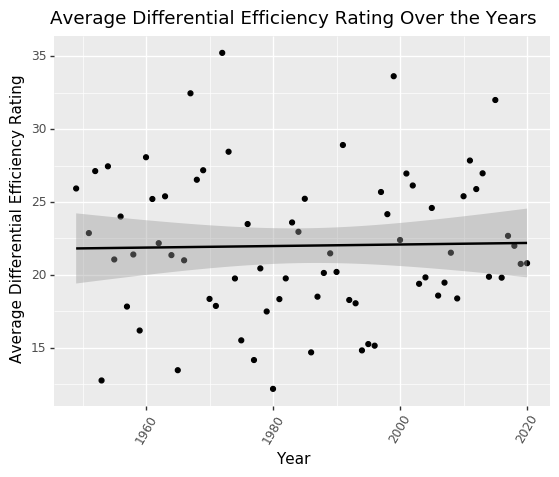

<ggplot: (7557602885)>

In [31]:
# Since both offensive and deffensive efficiencies are per points per 100 possesions, a simple differential will tell us which teams perform on average on both sides of the court
differenital = efficiency['offensive'] - efficiency['defensive']
efficiency.insert(1, 'differential', differenital)

(ggplot(efficiency, aes(x= 'year', y = 'differential')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Average Differential Efficiency Rating') +
ggtitle('Average Differential Efficiency Rating Over the Years') +
geom_smooth(method = 'lm'))

In [32]:
# The most efficient team on both sides of the court
efficiency[efficiency['differential'] == efficiency['differential'].max()]

team_name  differential  defensive   offensive  possesions    g   pts  \
1972      UCLA     35.227625   74.63611  109.863735   86.106667  1.0  94.6   

        opp_pts   fga        fta  ...    fg       tov    opp_fga   opp_orb  \
1972  64.266667  75.4  26.766667  ...  38.0 -0.033333  66.766667 -0.033333   

           drb     opp_fg   opp_tov    opp_fta      fg3a  year  
1972 -0.033333  25.533333 -0.033333  19.266667 -0.033333  1972  

[1 rows x 22 columns]

Interestingly, this team is widely considered one of the greatest of all time.
https://bleacherreport.com/articles/1046550-the-50-best-teams-in-college-basketball-history

In [33]:
# The least efficient team on both sides of the court
efficiency[efficiency['differential'] == efficiency['differential'].min()]

team_name  differential  defensive   offensive  possesions    g  \
1980    DePaul     12.180437  96.470915  108.651352   77.114286  1.0   

            pts    opp_pts   fga        fta  ...         fg       tov  \
1980  83.785714  74.392857  67.5  24.035714  ...  32.821429 -0.035714   

        opp_fga   opp_orb       drb     opp_fg   opp_tov    opp_fta      fg3a  \
1980  70.178571 -0.035714 -0.035714  31.392857 -0.035714  16.285714 -0.035714   

      year  
1980  1980  

[1 rows x 22 columns]

While the efficiency differential doesn't really show a trend, it does separate the best of the best teams. The 1972 UCLA Bruins had the best efficiency differential in our dataset, and went on to win the 1972 National Championship. More recently, the 2015 Kentucky team that was extremely efficient with a differential of ~32 made a Final Four run. On the other hand, the 1980 DePaul team had an awful efficiency differential, and was eliminated from the NCAA tournament in the Round of 32.

### Exploratory Data Analysis Tutorial

After collecting and processing the dataset, the next step is to visualize it. We must be mindful of what we are plotting to avoid the missing data values. 

Out of pure curiousity, we checked to see which schools produced the best teams most often, finding that Kentucky has produced 10 AP Poll #1 teams. Duke and UCLA aren't far behind with 8 teams apiece, and North Carolina, Kansas, and Ohio State behind them at 4 teams in our dataset.

Next, we filtered out rows with -1 values, and plotted trends in points, score differential, turnovers (and differential), 3 point shooting, and offensive / defensive efficiencies. In adddition to scatter plots, we overlayed a linear regression line and printed the linear model for each of our inquiries. 

Finally, we added a bit of prose between each inquiry to see what we could draw from our data analysis of those specific basketball statistic categories. 

Some statistics didn't show much, but others such as score differential, attempted three point shooting, and efficiency showed statistically significant trends that inform us on how NCAA basketball has evolved over the last 60+ years. From these trends, we can infer what is important to today's NCAA game, such as the run and gun 3 point shooting offenses, and efficient defenses.

# Part 4 - Hypothesis Testing and Machine Learning

If you haven't noticed, every scatter plot we've produced is accompanied by line of linear regression. It helps to establish certain trend indicators across time, and it is also the simplest form of machine learning. See, if you look at the offensive efficiency over time graph, you could extrapolate that in the future, teams will be more efficient in their scoring. Linear regression is simply a technique to minimize the cost function and the residuals, between our model and the data. 

Let’s create a new problem with our own hypothesis, one not involving time. It is often speculated in the new age of basketball, shooting more three point shots makes an offense more efficient. You can read more about this so-called “revolution” in basketball, and specifically college ball, here https://bleacherreport.com/articles/2762158-the-3-point-revolution-has-taken-over-college-basketball-too.

Our null hypothesis will be that there is no association between how a team's offensive efficiency and the number of threes they attempt. The alternate hypothesis is that there is a correlation between offensive efficiency and the number of attempted threes. 


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


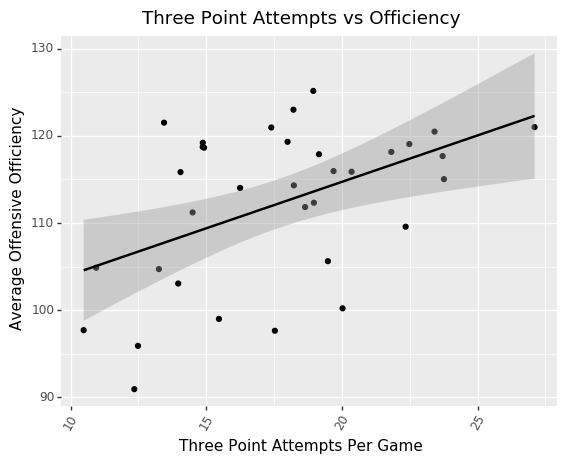

<ggplot: (7558155261)>

In [34]:
# First lets remove the columns with missing values, since the three point line was introduced to NCAA in 1986
efficiency.drop(efficiency[efficiency['fg3a'] < 0].index, inplace = True) 

# Plot regression
(ggplot(efficiency, aes(x= 'fg3a', y = 'offensive')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Three Point Attempts Per Game') + 
ylab('Average Offensive Officiency') +
ggtitle('Three Point Attempts vs Officiency') +
geom_smooth(method = 'lm'))

In [35]:
model = sm.ols('fg3a~offensive', data=efficiency).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fg3a   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     9.522
Date:                Sun, 17 May 2020   Prob (F-statistic):            0.00417
Time:                        16:05:48   Log-Likelihood:                -90.877
No. Observations:                  34   AIC:                             185.8
Df Residuals:                      32   BIC:                             188.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.4622      7.849     -0.823      0.416     -22.450       9.526
offensive      0.2151      0.070      3.086      0.004       0.073       0.357
==============================================================================
Omnibus:                        2.431   Durbin-Watson:                   1.432
Prob(Omnibus):                  0.297   Jarque-Bera (JB):                1.465
Skew:                           0.223   Prob(JB):                        0.481
Kurtosis:                       2.086   Cond. No.                     1.43e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

With this model we can see a linear regression model that fairly closely matches are expected result, that three-point attempts do correlate with offensive efficiency. If we look closely at our model, which utilizes the least squares method, has an R-squared value of 0.229 which is pretty good. The p-value which is used to accept or reject our null hypothesis, is very low at 0.004, much less than our needed alpha level of significance of 0.05. This means, we can reject our null hypothesis of no correlation between  offensive efficiency and three-point attempts. There is strong evidence that such a correlation between the two statistics exists. 

Then by extrapolating further, this linear regression model can further be used as predictive measure to show the predicted offensive efficiency based on the number of three’s attempted by top ranked college basketball teams.


# Part 5 - Final Thoughts

We hope you found this tutorial interesting and informative. Data science and sports go hand in hand, nowadays. It has become increasingly clear that professional, collegiate, and amateur sports teams can all utilize increased data analytics to improve their respective games. As found with this tutorial, top collegiate teams improve each coming year, and so do their opponents. 

Gaining a competitive edge is not an easy task. Teams can you use machine learning to best predict the most effective strategies, in our model, that was shooting more three pointers. If you want to do more research in this field, much has been written about data analytics in the NBA, and it can all be generalized to all levels of basketball. 

Here is some more information:

https://www.nytimes.com/2019/11/27/sports/basketball/nba-analytics.html 

These ones is all about the three-point shot: 

https://towardsdatascience.com/nba-data-analytics-changing-the-game-a9ad59d1f116 

https://onlinedsa.merrimack.edu/nba-analytics-changing-basketball/
